# Feedback Loops in Adaptive Learning Systems

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib  inline
from collections import OrderedDict, namedtuple
from math import sqrt, log
from random import random, randint, choice
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from models import create_proxy_student, create_true_student
from models import LearningSystem
from simulation import simulate_single_student

In [8]:
s = ProxyStudent(p_learn=0.1, p_good=[0.2, 0.7])
for i in range(10): 
    answer = int(randint(0, 5) > 3)
    s.update_skill(answer)
    print(str(answer) + ' : ' + str(s.skill))

0 : 0.136
1 : 0.4197014925373134
0 : 0.29201820940819423
0 : 0.2205596547403592
1 : 0.5478298949182049
0 : 0.38115999668402784
0 : 0.26887072761757447
0 : 0.20907294725299824
1 : 0.5325129111823
1 : 0.8195249095682802


In [10]:
s = TrueStudent(p_learn=1.0, p_good=(0.0, 1.))
for i in range(10): 
    answer = s.answer()
    print(str(answer) + ' : ' + str(s.skill))

1 : 1
1 : 1
1 : 1
1 : 1
1 : 1
1 : 1
1 : 1
1 : 1
1 : 1
1 : 1


In [31]:
#TrueStudent(bkt_params[0].)
s = create_true_student(0)
for i in range(10): 
    answer = s.answer()
    print(str(answer) + ' : ' + str(s.skill))

1 : 0
0 : 0
0 : 0
0 : 0
0 : 0
0 : 0
1 : 0
1 : 1
1 : 1
1 : 1


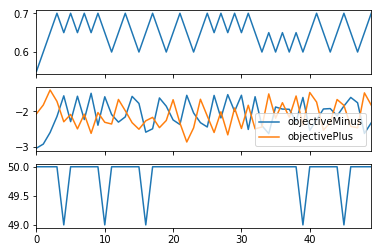

In [98]:
def perform_simulation(
        proxy_objective=proxy_objective_solved_tasks,
        i_student=0,
        n_iters=50,
        n_students=50):
    als = LearningSystem(threshold=0.5, proxy_objective=proxy_objective)
    thresholds = []
    objectivePlus, objectiveMinus = [], []
    mastery = []
    for i_iter in range(n_iters):
        true_students = create_students(n_students, i_student)
        als.do_iteration(true_students)
        thresholds.append(als.threshold)
        mastery.append(sum(int(s.n_answers < s.max_answers) for s in true_students))
        objectiveMinus.append(als.objectives[0])
        objectivePlus.append(als.objectives[1])
    results = pd.DataFrame({
        'thresholds': thresholds,
        'mastery': mastery,
        'objectiveMinus': objectiveMinus,
        'objectivePlus': objectivePlus})
    return results

def plot_simulation(results):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True)
    results.thresholds.plot(ax=ax1)
    results[['objectiveMinus', 'objectivePlus']].plot(ax=ax2)
    results.mastery.plot(ax=ax3)

def create_students(n_students, i_student):
    return [
        create_true_student(i_student)
        for _ in range(n_students)
    ]
    
plot_simulation(perform_simulation(
    proxy_objective=lambda s: proxy_objective_natural_success(s, 0.75)))

False


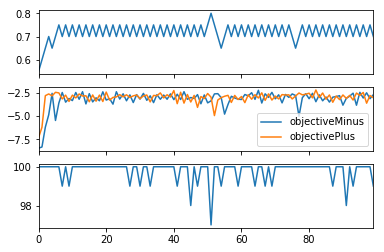

In [92]:
results = perform_simulation(
                proxy_objective=proxy_objective_natural_success,
                i_student=0,
                n_iters=100,
                n_students=100)
print(np.mean(np.abs(results.thresholds - 0.5) > 0.44) > 0.5)
plot_simulation(results)

In [101]:
def evaluate_system(
        proxy_objective=proxy_objective_successful_tasks,
        n_iters_system=50,
        n_systems=10,
        n_students=50):
    n_anomalies = 0
    for i_system in range(n_systems):
        for i_student in range(len(bkt_params)):
            results = perform_simulation(
                proxy_objective=proxy_objective,
                i_student=i_student,
                n_iters=n_iters_system,
                n_students=n_students
            )            
            n_anomalies += int(
                np.mean(np.abs(results.thresholds - 0.5) > 0.44) > 0.5
            )
    n_experiments = n_systems * len(bkt_params)
    return n_anomalies / n_experiments
            
evaluate_system(
    proxy_objective=lambda s: proxy_objective_natural_success(s, 0.7))

0.0